In [41]:
import warnings
warnings.simplefilter('ignore')

import math
import time
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import hypertools as hyp
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

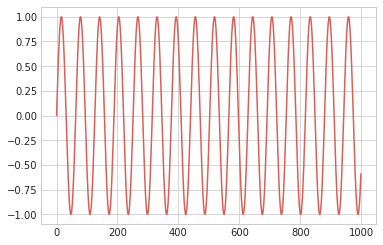

In [27]:
x = np.sin(np.arange(0, 500, 0.1))
plt.plot(x[:1000])

In [28]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(x[:, np.newaxis])
series = pd.DataFrame(data=scaled)

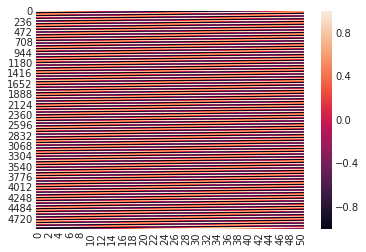

In [29]:
n = 50
series_s = series.copy()
for i in range(n):
    series = pd.concat([series, series_s.shift(-(i+1))], axis=1)
series.dropna(axis=0, inplace=True)
sns.heatmap(series.values)

In [35]:
n_train = int(0.67*series.shape[0])
train = series.iloc[:n_train, :]
test = series.iloc[n_train:, :]

In [56]:
train_in = train.iloc[:, :-3].values
train_out = train.iloc[:, -3:].values

test_in = test.iloc[:, :-3].values
test_out = test.iloc[:, -3:].values

In [57]:
train_in = train_in.reshape(train_in.shape[0], train_in.shape[1], 1)
test_in = test_in.reshape(test_in.shape[0], test_in.shape[1], 1)
train_in.shape, test_in.shape, train_out.shape, test_out.shape

((3316, 48, 1), (1634, 48, 1), (3316, 3), (1634, 3))

In [58]:
model = Sequential()
model.add(LSTM(input_shape=(train_in.shape[1], 1), output_dim=train_in.shape[1], return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 48, 48)            9600      
_________________________________________________________________
dropout_11 (Dropout)         (None, 48, 48)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 256)               312320    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 771       
_________________________________________________________________
activation_6 (Activation)    (None, 3)                 0         
Total params: 322,691
Trainable params: 322,691
Non-trainable params: 0
_________________________________________________________________


In [59]:
start = time.time()
model.fit(train_in, train_out, batch_size=512, nb_epoch=3, validation_split=0.1)
print("> Compilation time: ", time.time() - start)

Train on 2984 samples, validate on 332 samples
Epoch 1/3
2984/2984 [==============================] - 5s 2ms/step - loss: 0.3867 - val_loss: 0.1992
Epoch 2/3
2984/2984 [==============================] - 4s 1ms/step - loss: 0.0997 - val_loss: 0.0031
Epoch 3/3
2984/2984 [==============================] - 4s 1ms/step - loss: 0.0376 - val_loss: 0.0289
> Compilation time:  13.602668523788452


In [60]:
predictions = model.predict(test_in)
predictions = scaler.inverse_transform(predictions)
predictions.shape

(1634, 3)

In [61]:
observed = scaler.inverse_transform(test_out)
observed.shape

(1634, 3)

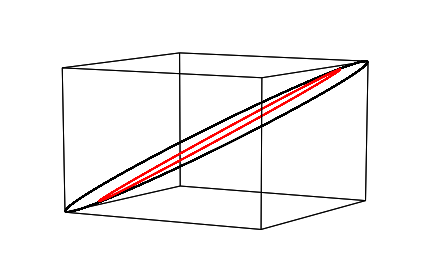

In [62]:
hyp.plot([observed, predictions], ['k-', 'r:'])

In [2]:
geo = hyp.load('weights');
x = geo.data[0]

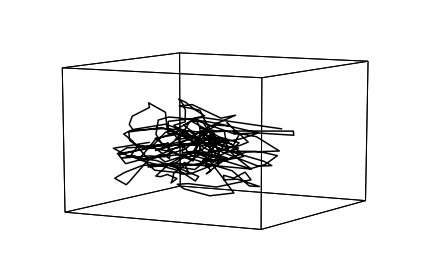

In [3]:
hyp.plot(x, 'k-')

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler.fit_transform(x)

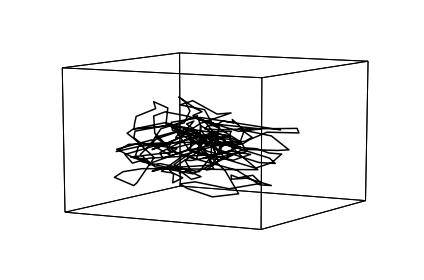

In [5]:
hyp.plot(x_scaled, 'k-')

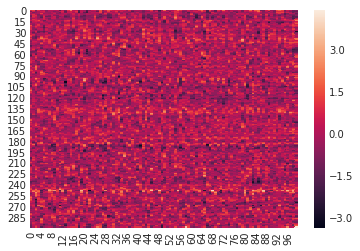

In [6]:
sns.heatmap(x)

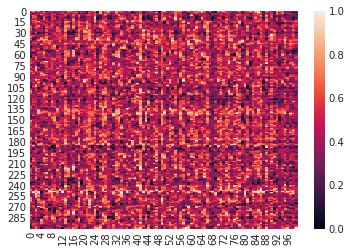

In [7]:
sns.heatmap(x_scaled)

In [8]:
train_size = int(x.shape[0] * 0.67)
test_size = x.shape[0] - train_size
train, test = x_scaled[0:train_size, :], x_scaled[train_size:, :]

In [9]:
def forward_project(x, n_steps):
    a, b, = x[n_steps:], x[:-n_steps]
    return a.reshape((a.shape[0], 1, a.shape[1])), b.reshape((b.shape[0], 1, b.shape[1]))
    #return a, b

In [10]:
n_steps = 1
train_in, train_out = forward_project(train, n_steps)
test_in, test_out = forward_project(test, n_steps)

In [11]:
train_in.shape, train_out.shape, test_in.shape, test_out.shape

((200, 1, 100), (200, 1, 100), (98, 1, 100), (98, 1, 100))

In [12]:
n_back = 5
epochs = 10

model = Sequential()
model.add(LSTM(epochs, input_shape=(train_in.shape[1], train_in.shape[2])))
model.add(Dense(train_in.shape[2], input_shape=(train_in.shape[2], )))
model.compile(loss='mae', optimizer='adam')

In [13]:
history = model.fit(train_in, train_out, epochs=epochs, batch_size=20, verbose=2, validation_data=(test_in, test_out), shuffle=False)

ValueError: Error when checking target: expected dense_1 to have 2 dimensions, but got array with shape (200, 1, 100)